In [2]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree



import networkx as nx

from scipy.spatial import distance

In [3]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

# Load the data 

In [4]:
%%time
rna_cna = pd.read_csv("../data/interim/FRP_copykat_CNA_results.txt", sep = "\t", index_col = 2)
rna_anno = pd.read_csv("../data/interim/FRP_copykat_CNA_raw_results_gene_by_cell.txt", sep = "\t",usecols = [0, 1, 2,3,4,5], index_col = 0)

CPU times: user 3min 24s, sys: 12.5 s, total: 3min 37s
Wall time: 3min 37s


In [5]:
rna_anno.head()

,chromosome_name,start_position,end_position,ensembl_gene_id,hgnc_symbol
abspos,,,,,
934254,1,923928,944581,ENSG00000187634,SAMD11
951756,1,944204,959309,ENSG00000188976,NOC2L
963151,1,960587,965715,ENSG00000187961,KLHL17
971181,1,966497,975865,ENSG00000187583,PLEKHN1
999567,1,998962,1000172,ENSG00000188290,HES4


In [6]:
chroms = rna_cna[["chrom"]]

In [7]:
rna_cna = rna_cna.drop(columns = ["chrom","chrompos"])


In [8]:
rna_cna.head()

,AAACAAGCAAACGGGA.1,AAACAAGCAAATAGGA.1,AAACAAGCAACAAGTT.1,AAACAAGCAACCATTC.1,AAACAAGCAACTAAAC.1,AAACAAGCAAGTCGCG.1,AAACAAGCAATACCCT.1,AAACAAGCAATGGGAG.1,AAACAAGCACAAGCGT.1,AAACAAGCACATTGTC.1,...,TTTGGCGGTTTACGAC.1,TTTGGCGGTTTGTGAC.1,TTTGTGAGTAAAGCAT.1,TTTGTGAGTACTTAGC.1,TTTGTGAGTCCGTGAC.1,TTTGTGAGTGATAAAC.1,TTTGTGAGTGGTTACT.1,TTTGTGAGTTACTTCT.1,TTTGTGAGTTGTCATA.1,TTTGTGAGTTTGGCCA.1
abspos,,,,,,,,,,,,,,,,,,,,,
1042457.0,-0.036124,-0.093622,0.098105,0.159482,0.113863,0.049553,0.024992,-0.055088,0.063074,0.073035,...,0.105740,-0.044175,-0.015850,0.061139,0.040408,0.084354,-0.110451,0.106061,0.054095,-0.051687
1265484.0,-0.036124,-0.093622,0.098105,0.159482,0.113863,0.049553,0.024992,-0.055088,0.063074,0.073035,...,0.105740,-0.044175,-0.015850,0.061139,0.040408,0.084354,-0.110451,0.106061,0.054095,-0.051687
1519859.0,-0.036124,-0.093622,0.098105,0.159482,0.113863,0.049553,0.024992,-0.055088,0.063074,0.073035,...,0.105740,-0.044175,-0.015850,0.061139,0.040408,0.084354,-0.110451,0.106061,0.054095,-0.051687
1826619.0,-0.036124,-0.093622,0.098105,0.159482,0.113863,0.049553,0.024992,-0.055088,0.063074,0.073035,...,0.105740,-0.044175,-0.015850,0.061139,0.040408,0.084354,-0.110451,0.106061,0.054095,-0.051687
2058465.0,0.008697,-0.135474,0.023012,-0.000307,-0.153787,-0.000637,0.000069,0.000235,-0.059653,0.000031,...,0.040347,-0.016430,-0.184834,-0.150781,0.043961,0.000039,-0.021113,-0.134849,0.024735,-0.044809


In [9]:
rna_cna.columns = [x.replace(".","-") for x in rna_cna.columns]

In [10]:
rna_anno["abspos"] = rna_anno.index

# Clustering

## Filtering

In [11]:
rna_var = rna_cna.std(axis = 0)

In [12]:
rna_cell_anno = pd.read_csv("../data/interim/FRP_copykat_prediction.txt", sep = "\t", index_col = 0)

In [13]:
rna_var

AAACAAGCAAACGGGA-1    0.021886
AAACAAGCAAATAGGA-1    0.046243
AAACAAGCAACAAGTT-1    0.027815
AAACAAGCAACCATTC-1    0.043006
AAACAAGCAACTAAAC-1    0.093684
                        ...   
TTTGTGAGTGATAAAC-1    0.020027
TTTGTGAGTGGTTACT-1    0.043180
TTTGTGAGTTACTTCT-1    0.079635
TTTGTGAGTTGTCATA-1    0.037912
TTTGTGAGTTTGGCCA-1    0.034928
Length: 24954, dtype: float64

In [14]:
rna_var.name = "variance"

In [15]:
rna_var

AAACAAGCAAACGGGA-1    0.021886
AAACAAGCAAATAGGA-1    0.046243
AAACAAGCAACAAGTT-1    0.027815
AAACAAGCAACCATTC-1    0.043006
AAACAAGCAACTAAAC-1    0.093684
                        ...   
TTTGTGAGTGATAAAC-1    0.020027
TTTGTGAGTGGTTACT-1    0.043180
TTTGTGAGTTACTTCT-1    0.079635
TTTGTGAGTTGTCATA-1    0.037912
TTTGTGAGTTTGGCCA-1    0.034928
Name: variance, Length: 24954, dtype: float64

In [16]:
rna_cell_anno

,copykat.pred
cell.names,
AAACAAGCAAACGGGA-1,diploid
AAACAAGCAAATAGGA-1,aneuploid
AAACAAGCAACAAGTT-1,diploid
AAACAAGCAACCATTC-1,diploid
AAACAAGCAACTAAAC-1,aneuploid
...,...
TTTGTGAGTGGTTACT-1,not.defined
TTTGTGAGTGTTCCAG-1,not.defined
TTTGTGAGTTACTTCT-1,not.defined


In [17]:
rna_cell_anno = rna_cell_anno.merge(rna_var, right_index=True, left_index=True)

In [18]:
rna_cell_anno = rna_cell_anno.sort_values(by = "variance", ascending = False)

In [19]:
rna_cell_anno["id"] = np.arange(0, len(rna_cell_anno))

In [20]:
rna_cell_anno

,copykat.pred,variance,id
cell.names,,,
CGCAAGGGTTAGTGAG-1,aneuploid,0.158918,0
CGCAAGGGTTAGTGAG-1,not.defined,0.158918,1
CAAGACTAGCTTGAGG-1,not.defined,0.139916,2
CAAGACTAGCTTGAGG-1,aneuploid,0.139916,3
GCCAATACATTGCCTG-1,aneuploid,0.136529,4
...,...,...,...
CCAATTTAGACTCAAA-1,diploid,0.015100,49613
ACCAACTGTCGTTCTC-1,not.defined,0.014065,49614
ACCAACTGTCGTTCTC-1,diploid,0.014065,49615


<Axes: xlabel='id', ylabel='variance'>

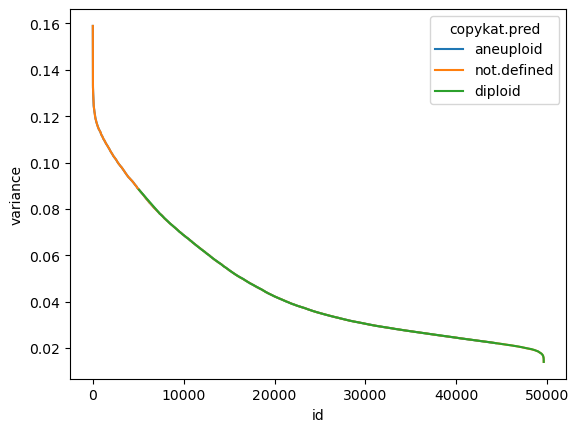

In [21]:
sns.lineplot(data = rna_cell_anno, y = "variance", hue = "copykat.pred", x = "id")

<Axes: xlabel='id', ylabel='variance'>

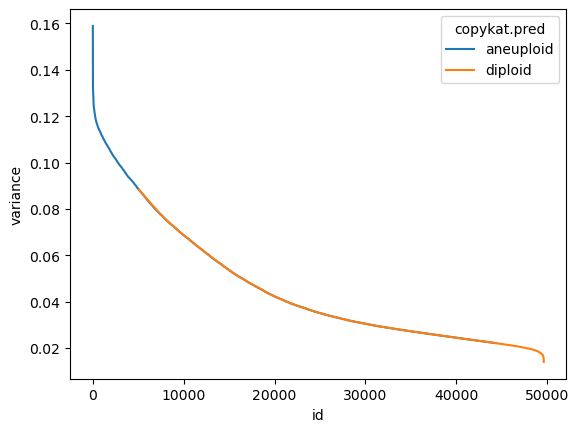

In [22]:
sns.lineplot(data = rna_cell_anno[rna_cell_anno["copykat.pred"]!="not.defined"]
, y = "variance", hue = "copykat.pred", x = "id")

In [23]:
tumor_cells_rna = rna_cell_anno[(rna_cell_anno["copykat.pred"]!="not.defined") & (rna_cell_anno.variance >= 0.04)].index

In [24]:
rna_cell_anno["tumor"] = rna_cell_anno.variance >= 0.04

In [25]:
rna_cna = rna_cna.T

In [26]:
rna_cna = rna_cna.loc[tumor_cells_rna]

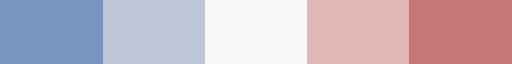

In [27]:
newcmp = list(sns.color_palette("vlag",5))
newcmp[2] = "#F9F9F9"
newcmp = ListedColormap(newcmp)   
newcmp

## scRNA

In [28]:
adata_sc = sc.AnnData(rna_cna)


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [29]:
num_comp = 50
sc.tl.pca(adata_sc, svd_solver='arpack', n_comps = num_comp)

In [30]:
print(np.cumsum(adata_sc.uns["pca"]['variance_ratio'])[-1])


0.8810333648078673


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


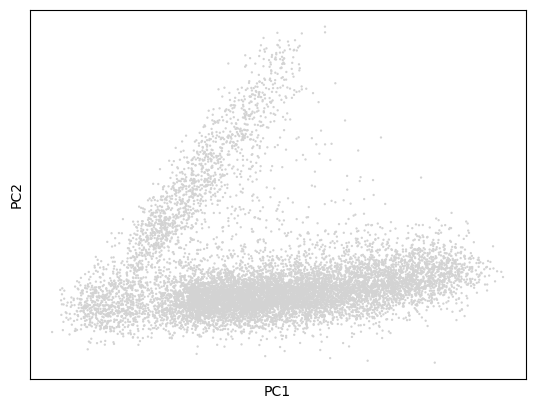

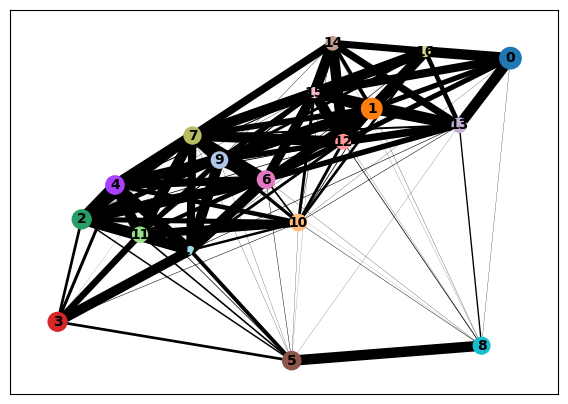

In [31]:
sc.pl.pca(adata_sc)
sc.pp.neighbors(adata_sc, n_pcs=num_comp)
sc.tl.leiden(adata_sc, resolution = 2)
sc.tl.paga(adata_sc)
sc.pl.paga(adata_sc, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_sc, init_pos='paga')


In [32]:
adata_sc.write("../data/interim/cnv.h5ad")


/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/scdna/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


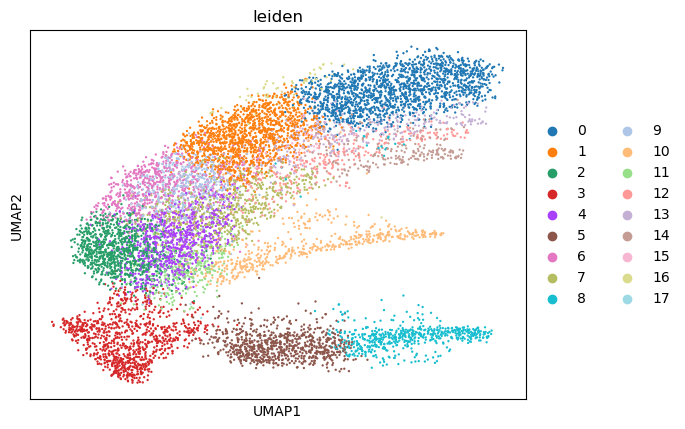

In [33]:
sc.pl.umap(adata_sc, color = "leiden")

In [34]:
clones_sc = adata_sc.obs[["leiden"]]

In [35]:
#change data type of clones_vis to int
clones_sc["leiden"] = clones_sc.leiden.astype(int)

In [36]:
import PyComplexHeatmap
from PyComplexHeatmap import *
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [37]:
clones_sc

,leiden
cell.names,
CGCAAGGGTTAGTGAG-1,16
CAAGACTAGCTTGAGG-1,16
GCCAATACATTGCCTG-1,10
CTTCAATAGATGATTG-1,10
GATGCAAGTATTGCGT-1,10
...,...
TCTAACCCAGGTATTG-1,2
TCAACTAGTTAGCGCC-1,3
CAGGTCAAGACCATTT-1,2


In [54]:
col = {'1': '#999993',
 '2': '#eeeee4',
 '3': '#999993',
 '4': '#eeeee4',
 '5': '#999993',
 '6': '#eeeee4',
 '7': '#999993',
 '8': '#eeeee4',
 '9': '#999993',
 '10': '#eeeee4',
 '11': '#999993',
 '12': '#eeeee4',
 '13': '#999993',
 '14': '#eeeee4',
 '15': '#999993',
 '16': '#eeeee4',
 '17': '#999993',
 '18': '#eeeee4',
 '19': '#999993',
 '20': '#eeeee4',
'21': '#999993',
'22': '#eeeee4',
'23':'#999993',
 'X': '#999993',
 'Y': '#eeeee4'}

In [39]:
sys.setrecursionlimit(10000)


In [41]:
rna_cna.shape

(10721, 12167)

In [53]:
chroms.chrom.unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype=object)

In [51]:
chroms.chrom = chroms.chrom.astype(str)

In [ ]:
plt.figure(figsize=(19, 12))

col_ha = HeatmapAnnotation(chrom = anno_simple(chroms.chrom,add_text=True, colors = col, text_kws ={"color": "black"} ),
                           plot_legend = False, axis = 1, plot = False)
row_ha = HeatmapAnnotation(assay = anno_simple(clones_sc.leiden,add_text=True,legend_kws={'frameon':False},text_kws={'fontsize':10} ),plot_legend = False,
                          axis = 0,label_kws = {'visible':False}, legend_width = 2, hgap =0.01, plot = False)
cm1 = ClusterMapPlotter(data=rna_cna,row_dendrogram=True,show_rownames=False,show_colnames=False,top_annotation = col_ha,
                       row_cluster_metric = "euclidean",col_cluster = False,
                      row_cluster = True, label='log ratio', cmap = newcmp, right_annotation = row_ha)


plt.show()

Starting plotting..
Starting calculating row orders..
Reordering rows..


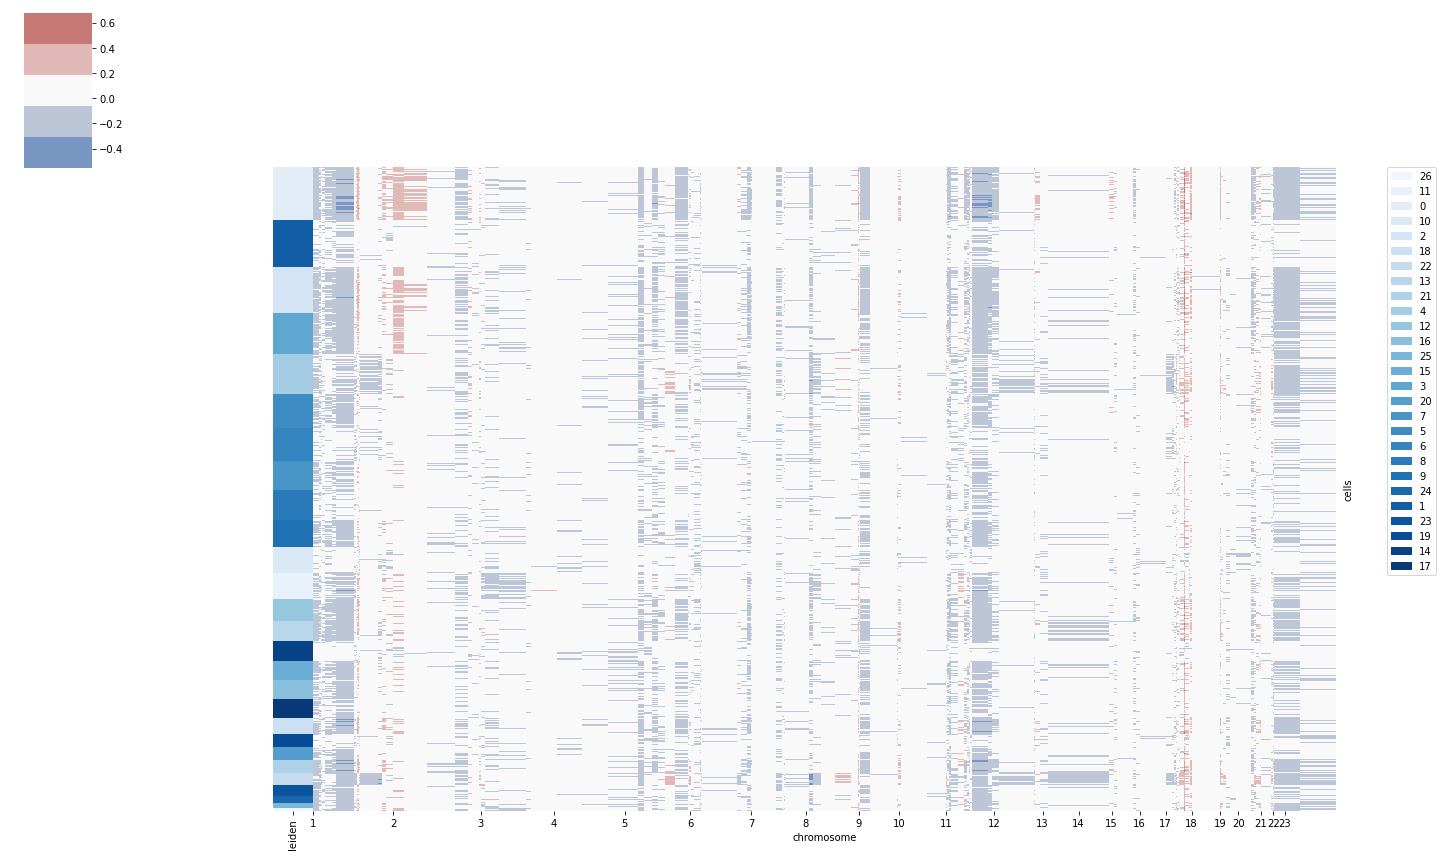

In [72]:
g = sns.clustermap(tmp_sc, row_colors = row_colors_sc, cmap = newcmp, figsize = (19,12), xticklabels = False, yticklabels = False,
                   col_cluster = False, row_cluster = False)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("cells")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()

    
handles = [mpatches.Patch(color=lut_sc[key], label=key) for key in lut_sc]
g.ax_heatmap.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [73]:
clones = clones_sc.sort_values().values

In [74]:
cons_sc = []
sc_clone_size = {}
for cl in range(len(set(clones))):
    idx = np.where(clones == cl)[0]
    values = tmp_sc.iloc[idx]
    values = values.median().values
    cons_sc.append(values)
    sc_clone_size[cl] = len(idx)
    

In [75]:
sc_clone_size

{0: 879,
 1: 782,
 2: 763,
 3: 689,
 4: 655,
 5: 580,
 6: 537,
 7: 493,
 8: 490,
 9: 456,
 10: 433,
 11: 425,
 12: 372,
 13: 331,
 14: 329,
 15: 320,
 16: 320,
 17: 317,
 18: 262,
 19: 229,
 20: 214,
 21: 203,
 22: 202,
 23: 197,
 24: 106,
 25: 87,
 26: 50}

In [76]:
cons_sc = pd.DataFrame(cons_sc, columns = tmp_sc.columns)

/omics/groups/OE0540/internal/B260/users/olga/.conda/envs/torch_geo/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


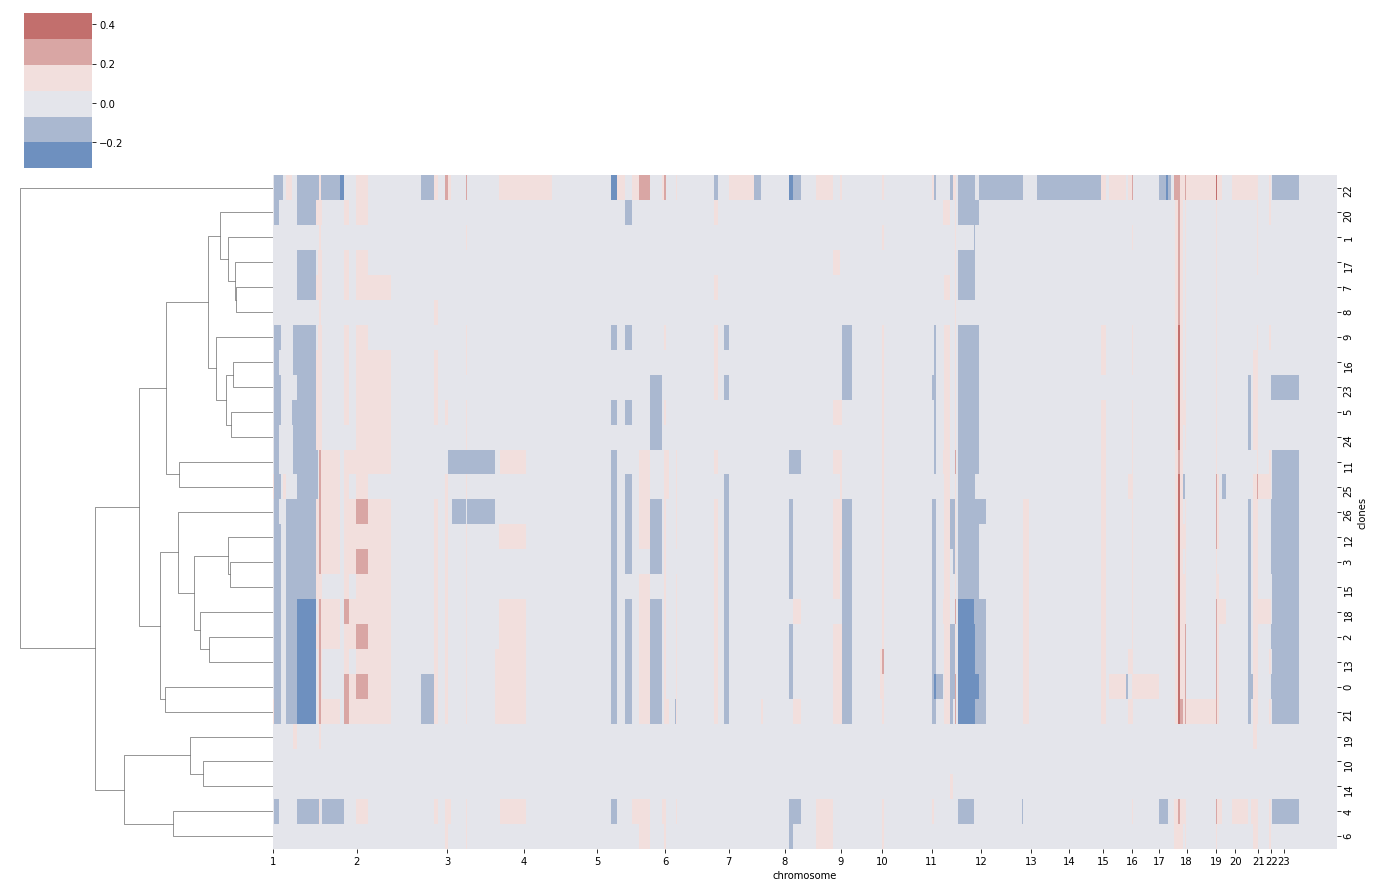

In [85]:

g = sns.clustermap(cons_sc, cmap = sns.color_palette("vlag"), figsize = (19,12), xticklabels = False,
                   col_cluster = False, row_cluster = True)
ax = g.ax_heatmap
ax.set_xlabel("chromosome")
ax.set_ylabel("clones")
cut_chroms = chroms

ax.set_xticks(range(0, len(cut_chroms)), cut_chroms)
xticks = ax.xaxis.get_major_ticks()
prev = ""
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() == prev:
        label.set_visible(False)
        xticks[i].set_visible(False)
    prev = label.get_text()




In [80]:
cons = cons_sc.T.copy()
diploid_id = cons.columns[-1]+1
cons[diploid_id] = 0
cons = cons.T
n_clusters = cons.shape[0]
X = np.zeros((n_clusters, n_clusters))
for c1 in range(n_clusters):
    cells1 = cons.loc[c1]
    for c2 in range(n_clusters):

        cells2 =  cons.loc[c2]
        dist = np.linalg.norm(cells1-cells2)
        X[c1,c2] = dist
        if c1 != c2 and dist ==0:
            dist = 1e-06
            X[c1,c2] = dist

In [81]:
np.save("../data/interim/clone_dist_over.npy",1-X/X.max())

In [82]:
X = np.tril(X, -1)
X = csr_matrix(X)
Tcsr = minimum_spanning_tree(X)
tree = Tcsr.toarray().astype(int)

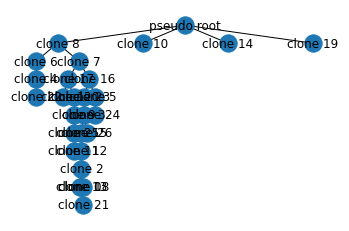

In [84]:
G = nx.Graph()
root = diploid_id

for i in range(np.shape(tree)[0]):
    for j in range(i+1,np.shape(tree)[0]):
        if tree[j,i]>0:
            if i == diploid_id:
                node_i_l = "sudo root"
                node_j_l = f"clone {j}"
            elif j == diploid_id:
                node_j_l = "sudo root"
                node_i_l = f"clone {i}"
            else:
                node_i_l = f"clone {i}"
                node_j_l = f"clone {j}"

            G.add_node(i)
            G.add_node(j)

            G.add_edge(i,j)


#colors = [node_colors.to_dict()[i] for i in G.nodes]
mapping = {x:f"clone {x}" if x !=diploid_id else "pseudo root" for x in G.nodes}
H = nx.relabel_nodes(G, mapping)
pos = hierarchy_pos(H,"pseudo root")  
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
nx.draw(H,pos, with_labels=True, node_size = 300, ax = ax )

In [86]:
adata_sc.obs["leiden"].to_csv("../data/interim/clones_over.csv")